Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Learning openCypher - Variable Length Path Queries

This notebook is the second in a series of notebooks that walk through how to write queries using openCypher.  In this notebook, we will examine the basics of how to perform variable length path queries in openCypher.  


This notebook will build upon the items convered in the notebook "01-Basic-Read-Queries". If you have not loaded the data from those notebooks please follow the steps in the [Getting Started](#Getting-Started) section below.  If you have loaded the data then you can jump ahead to the [Setting up the visualizations](#Setting-up-the-visualizations) section.



## Getting Started <a id='Getting-Started'></a>

For these notebooks, we will be leveraging a dataset from the book [Graph Databases in Action](https://www.manning.com/books/graph-databases-in-action?a_aid=bechberger) from Manning Publications.  


**Note:** These notebooks do not cover data modeling or building a data loading pipeline.  If you would like a more detailed description about how this dataset is constructed and the design of the data model came from, then please read the book.

To get started, the first step is to load data into the cluster.  Assuming the cluster is empty, this can be accomplished by running the cell below which will load our Dining By Friends data.

### Loading Data

In [ ]:
%seed --model Property_Graph --dataset dining_by_friends --run

### Looking at our graph data

Now that we have loaded our data, let's take a moment to look at what our data model looks like:


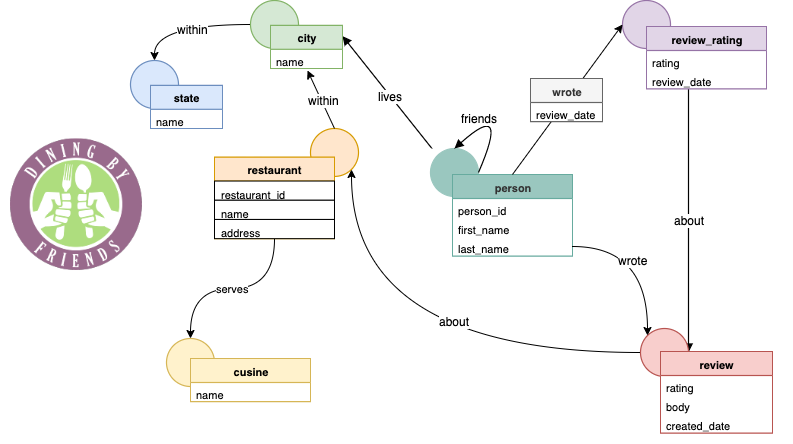

<table>
    <tr><th colspan=3 style="text-align: center">Element (Node/Edge) Counts</th>
    </tr>
<tr><td style="width:40%">
    
|Node Label|Count|
|:--|:--|
|review|109|
|restaurant|40|
|cuisine|24|
|person|8|
|state|2|
|city|2|
    
</td>
    <td></td>
    <td style="width:40%">

|Edge Label|Count|
|:--|:--|
|wrote|218|
|about|218|
|within|84|
|serves|80|
|friends|20|
|lives|16|

</td></tr> </table>

This dataset represents a fictitious, but realistic, restaurant recommendation application that contains:

* Users, represented by `person` nodes
* Users connected to Users via `friends` edges
* Restaurants and their associated information (`city`, `state`, `cusine`)
* Reviews include the body and ratings
* Ratings of reviews (helpful/not helpful)

This application contains three main aspects to the data it collects.  First, it contains a social network consisting of `person` nodes connected to other `person` nodes via a `friends` edge.  Second, it contains a restaurant review aspect consisting of `restaurant` nodes, information about those restaurants (`city`/`state`/`cuisine`), and `review` nodes for that restaurant.  The third, and final aspect, consists of a personalization component where a `person` can rate a `review`, which allows for better recommendations based on a person's preferences.

Throughout this set of notebooks, we will leverage the different aspects of this data to highlight different fundamental types of common property graph queries, namely neighborhood traversals, hierarchies, paths, and collaborative filtering.

Now let's get started.

### Setting up the visualizations

Run the next two cells to configure various display options for our notebook, which we will use later on to display our results in a pleasing visual way.  

In [ ]:
%%graph_notebook_vis_options
{
  "groups": {    
    "person": {
      "color": "#9ac7bf"
    },
    "review": {
      "color": "#f8cecc"
    },
    "city": {
      "color": "#d5e8d4"
    },
    "state": {
      "color": "#dae8fc"
    },
    "review_rating": {
      "color": "#e1d5e7"
    },
    "restaurant": {
      "color": "#ffe6cc"
    },
    "cusine": {
      "color": "#fff2cc"
    }
  }
}

In [ ]:
node_labels = '{"person":"first_name","city":"name","state":"name","restaurant":"name","cusine":"name"}'


## Variable Length Paths

When working with any property graph, some of the most powerful queries you can write are ones where the number of connections between a source and a target entity is not known.  These types of queries are so common that property graph query languages, such as openCypher, have first class support as a key piece of the query language.  In openCypher, these queries are written using a mechanism known as Variable Length Path patterns or VLPs.   VLPs allow us to specify a sequence of nodes and relationships, as well as the number of times to repeat the relationship in the pattern matching syntax.  

In openCypher, a basic VLP query to find all nodes within 1 to 3 hops looks like:

```
MATCH p=(:person)-[:friends*1..3]->(:person)
RETURN p
```

Examining this query we see that, while this looks familiar, there are a few new elements to the relationship syntax to highlight, specifically the `*1..3` portion.  This portion begins with an asterisk(`*`) indicating that this is a VLP query.  The next number represents the minimum length of the path, which is followed by two periods (`..`) and the maximum length of the path.  

While this is the basic pattern for VLP queries, there are several different variants which are shown in the table below: 

#### Variable Length Path Syntax

|   VLP Pattern|Description|
|:--|:--|
|`()-[*2]->()`|Find me a path containing 3 nodes and 2 edges|
|`()-[*2..3]->()`|Find me a path containing a minimum of 3 nodes and 2 edges and a maximum of 4 nodes and 3 relationships|
|`()-[*2..]->()`|Find me a path containing a minimum of 3 nodes and 2 edges, with no maximum|
|`()-[*..2]->()`|Find me a path containing a maximum of 3 nodes and 2 edges, with no minimum|
|`()-[*]->()`|Find me a path with no minimum or maximum|


Now that we have a basic understanding of openCypher's VLP syntax, let's look at how this is applied to answer some common graph query patterns.

### Static Length paths

The simplest VLP pattern you can do in openCypher is to specify a fixed number of loops/iterations for your pattern.  This is accomplished using the syntax `()-[:friends*2]->()`.  Let's execute the query below to search for patterns containing 3 nodes and 2 edges.

In [ ]:
%%oc -d $node_labels
MATCH p=()-[:friends*2]->()
RETURN p  
LIMIT 10 

Looking at the above query, you'll notice that this seems familiar to our Friends of Friends query from the last notebook.  In truth, this query can be written using either VLP syntax or as we previously learned (`MATCH p=()-[:friends]->()-[:friends]->()`).  Why would you want to use VLP syntax here?

The main reason you might prefer VLP syntax here is that it can provide a significantly more readable query to the user.  While the queries we are currently looking at are very straightforward, as they get more complex, and the patterns being matched get longer, it can be very helpful to have a shorter, more concise query to make it easier to understand what the expectations of the query.  For example, the VLP pattern:

```
MATCH p=()-[:friends*6]->()
```
Is much more understandable than the non-VLP pattern:

`MATCH p=()-[:friends]->()-[:friends]->()-[:friends]->()-[:friends]->()-[:friends]->()-[:friends]->()`

Even though they are functionally equivalent.

### A range of lengths

While the example above works on a static length of paths, sometimes we do not know the number of connections we need to traverse to answer a question.  In this case, we can use the minimum and maximum range parameters of our VLP pattern to specify the range of potential connections.

#### Minimum length
Let's take the query from the last cell and modify it to specify only the minimum length of the pattern instead of a fixed length.  We accomplish this by replacing the `*2` with a  `*2..`.  


Execute the query below to see how many paths are connected via a minimum of 2 `friends` edges.

In [ ]:
%%oc -d $node_labels
MATCH p=()-[:friends*2..]->()
RETURN p  
LIMIT 10 

#### Maximum length
Now, let's modify that same query to specify only the maximum length of the pattern, by adding `*..2`.  

Execute the query below to see how many paths are connected via a maximum of 2 `friends` edges.

In [ ]:
%%oc -d $node_labels
MATCH p=()-[:friends*..2]->()
RETURN p  
LIMIT 10      

#### Minimum and Maximum length
Let's combine these last 2 queries together to specify both the minimum and the maximum length of the pattern, by adding `*1..2`.  Execute the query below to see how many paths are connected via a minimum of 1 `friends` edge and maximum of 2 `friends` edges.
 

In [ ]:
%%oc -d $node_labels
MATCH p=()-[:friends*1..2]->()
RETURN p  
LIMIT 10   

#### Unbounded Patterns
The final way to use VLP syntax is to not specify any minimum or maximum length and instead go for an unbounded range on the pattern.  This is accomplished by adding just the asterisk (`*`).  


**Important:** While this is a valid query, these sorts of queries tend to have a very high latency as they may traverse/touch a large portion of the graph, depending on how the graph is connected.

Execute the query below to see how many paths are connected via any number of `friends` edges. 

In [ ]:
%%oc -d $node_labels
MATCH p=()-[:friends*]->()
RETURN p  
LIMIT 10   

## Exercises

Now that we have gone through the basics of VLP queries in openCypher, it's time to put it into practice.  Below are several exercises you can complete to verify your understanding of the material covered in this notebook.  As practice for what you have learned, please write the openCypher queries specified below.

### Exercise VLP-1 Find the friends of Dave's Friends using a VLP

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Find the friends of that person (i.e. traverse the `friends` edge)
* Return the friends `first_name`

The correct answer is three results: "Hank", "Denise", "Paras"

In [ ]:
%%oc -d $node_labels


### Exercise VLP-2 Find all `person` nodes connected to Dave

Starting at a single node and trying to find all connected children (a.k.a. root to leaf) or trying to find the parent of any child node (a.k.a leaf to root) are two very common hierarchical graph query patterns.  Commonly, these queries supported bill of materials, information organization, or compliance use cases.

In this exercise, we will be applying that same query pattern to find the hierarchy of people within our social network.  We'll accomplish this vby writing a "root to leaf" type query where the root node is our `Dave` node in the social network.

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Keep traversing the outgoing `friends` edge until there are no more outgoing `friends` edges
* Return all the paths

The correct answer is nine results

In [ ]:
%%oc -d $node_labels


### Exercise VLP-3 Find if Dave and Denise are connected

Attempting to see if, and how two entities in a graph are connected is a common path type query pattern. These types of queries containing unbounded path traversals with an OLTP graph database are best for calculating point to point or point to set path questions.  Set to set or all pairs paths are best done with graph algorithms.

In this exercise, we will be applying a path type query pattern to find out if two people are connected.

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Keep traversing the `friends` edge until you find `Denise`
* Return a single `True` as the result

The correct answer is a single result: `True`

In [ ]:
%%oc -d $node_labels


### Exercise VLP-4 Find all the ways Dave and Denise are connected

A common extension to the path traversal query we wrote in VLP-3 is to return not just "if" someone is connected but "how" they are connected.

In this exercise, we will be making a slight modification to the previous query to return "how" Dave and Denise are connected, not just that they are.

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Keep traversing the `friends` edge until you find `Denise`
* Return the path

The correct answer has fifteen results

In [ ]:
%%oc -d $node_labels


## Conclusion

In this notebook, we explored writing variable length path queries in openCypher queries.  These queries are a powerful and common way to explore connected data to answer questions, especially those where the exact number of connection is unknown.  

In the next notebook, we will take what we have learned in this notebook and extend it to demonstrate how to order, group, and aggregate values in queries.